# PART 1: Forecasting by Product and Size

# Import Libraries

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn
!pip install statsmodels plotly
!pip install shap lime
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6bc4c9568a95f4470c1f73e372a62b8a65096edef02c191e34b9a1a2df004897
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Machine Learning
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

# Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

# Explainable AI
import shap
from lime.lime_tabular import LimeTabularExplainer

# Scipy for statistical analysis
from scipy import stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# Data Loading and Initial Exploration

In [ ]:
from google.colab import files
import io

print("Please upload your data files:")
print("1. sales_data.xlsx")
print("2. inventory_data.xlsx")

# Upload files
uploaded = files.upload()

Please upload your data files:
1. sales_data.xlsx
2. inventory_data.xlsx


Saving sales_data.xlsx to sales_data.xlsx
Saving inventory_data.xlsx to inventory_data.xlsx


In [193]:
# Load the data
sales_df = pd.read_excel('sales_data.xlsx')
inventory_df = pd.read_excel('inventory_data.xlsx')

In [194]:
sales_df.shape

(485, 45)

In [ ]:
inventory_df.shape

(484, 6)

In [ ]:
sales_df.head()

,Category,Product,Code,Size,2022-01-01 00:00:00,2022-02-01 00:00:00,2022-03-01 00:00:00,2022-04-01 00:00:00,2022-05-01 00:00:00,2022-06-01 00:00:00,...,2024-08-01 00:00:00,2024-09-01 00:00:00,2024-10-01 00:00:00,2024-11-01 00:00:00,2024-12-01 00:00:00,2025-01-01 00:00:00,2025-02-01 00:00:00,2025-03-01 00:00:00,2025-04-01 00:00:00,2025-05-01 00:00:00
0,Alfriston College,ALF Boys Ink Trousers,US PT 703L ALF -100,100,6.0,7.0,1.0,NaN,1.0,2.0,...,2.0,NaN,2.0,NaN,NaN,5.0,7.0,1.0,3.0,2.0
1,Alfriston College,ALF Boys Ink Trousers,US PT 703L ALF -104,104,5.0,6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.0,NaN,NaN,13.0,1.0,1.0,1.0,2.0
2,Alfriston College,ALF Boys Ink Trousers,US PT 703L ALF -108,108,1.0,1.0,2.0,2.0,3.0,NaN,...,1.0,NaN,NaN,NaN,NaN,7.0,3.0,NaN,2.0,3.0
3,Alfriston College,ALF Boys Ink Trousers,US PT 703L ALF -112,112,4.0,6.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,2.0,2.0
4,Alfriston College,ALF Boys Ink Trousers,US PT 703L ALF -116,116,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,5.0,NaN,NaN,NaN


In [ ]:
inventory_df.head()

,Category,Product,Code,Size,Stock On Hand,Lead Time (Weeks)
0,Alfriston College,ALF Boys Ink Trousers,US PT 703L ALF -100,100,38,5
1,Alfriston College,ALF Boys Ink Trousers,US PT 703L ALF -104,104,30,5
2,Alfriston College,ALF Boys Ink Trousers,US PT 703L ALF -108,108,15,5
3,Alfriston College,ALF Boys Ink Trousers,US PT 703L ALF -112,112,8,5
4,Alfriston College,ALF Boys Ink Trousers,US PT 703L ALF -116,116,5,5


In [195]:
print("Sales data columns:", list(sales_df.columns))

Sales data columns: ['Category', 'Product', 'Code', 'Size', datetime.datetime(2022, 1, 1, 0, 0), datetime.datetime(2022, 2, 1, 0, 0), datetime.datetime(2022, 3, 1, 0, 0), datetime.datetime(2022, 4, 1, 0, 0), datetime.datetime(2022, 5, 1, 0, 0), datetime.datetime(2022, 6, 1, 0, 0), datetime.datetime(2022, 7, 1, 0, 0), datetime.datetime(2022, 8, 1, 0, 0), datetime.datetime(2022, 9, 1, 0, 0), datetime.datetime(2022, 10, 1, 0, 0), datetime.datetime(2022, 11, 1, 0, 0), datetime.datetime(2022, 12, 1, 0, 0), datetime.datetime(2023, 1, 1, 0, 0), datetime.datetime(2023, 2, 1, 0, 0), datetime.datetime(2023, 3, 1, 0, 0), datetime.datetime(2023, 4, 1, 0, 0), datetime.datetime(2023, 5, 1, 0, 0), datetime.datetime(2023, 6, 1, 0, 0), datetime.datetime(2023, 7, 1, 0, 0), datetime.datetime(2023, 8, 1, 0, 0), datetime.datetime(2023, 9, 1, 0, 0), datetime.datetime(2023, 10, 1, 0, 0), datetime.datetime(2023, 11, 1, 0, 0), datetime.datetime(2023, 12, 1, 0, 0), datetime.datetime(2024, 1, 1, 0, 0), datetime.

In [196]:
print("Inventory data columns:", list(inventory_df.columns))

Inventory data columns: ['Category', 'Product', 'Code', 'Size', 'Stock On Hand', 'Lead Time (Weeks)']


# Data Understanding and Quality Assessment

In [ ]:
sales_df.dtypes

,0
Category,object
Product,object
Code,object
Size,object
2022-01-01 00:00:00,float64
2022-02-01 00:00:00,float64
2022-03-01 00:00:00,float64
2022-04-01 00:00:00,float64
2022-05-01 00:00:00,float64
2022-06-01 00:00:00,float64


In [197]:
sales_df['Product'].nunique()

40

In [198]:
sales_df['Category'].nunique()

4

In [199]:
sales_df['Size'].nunique()

100

In [ ]:
inventory_df.dtypes

,0
Category,object
Product,object
Code,object
Size,object
Stock On Hand,int64
Lead Time (Weeks),int64


In [200]:
inventory_df['Product'].nunique()

40

In [201]:
inventory_df['Stock On Hand'].mean()

np.float64(28.946280991735538)

In [202]:
inventory_df['Lead Time (Weeks)'].mean()

np.float64(5.117768595041323)

In [203]:
sales_df.isnull().sum()# Check for missing values

,0
Category,0
Product,1
Code,1
Size,1
2022-01-01 00:00:00,234
2022-02-01 00:00:00,243
2022-03-01 00:00:00,395
2022-04-01 00:00:00,405
2022-05-01 00:00:00,351
2022-06-01 00:00:00,383


In [204]:
inventory_df.isnull().sum()# Check for missing values

,0
Category,0
Product,0
Code,0
Size,0
Stock On Hand,0
Lead Time (Weeks),0


# Comprehensive Missing Value Analysis

In [205]:
def comprehensive_missing_analysis(df, name):
    """Perform comprehensive missing value analysis"""
    print(f"\n{name.upper()} - MISSING VALUE ANALYSIS:")
    print("-" * (len(name) + 30))

    # Basic missing value counts
    missing_counts = df.isnull().sum()
    missing_percentages = (missing_counts / len(df)) * 100

    missing_summary = pd.DataFrame({
        'Column': missing_counts.index,
        'Missing_Count': missing_counts.values,
        'Missing_Percentage': missing_percentages.values,
        'Data_Type': df.dtypes.values
    })

    missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

    if len(missing_summary) > 0:
        print("Columns with missing values:")
        print(missing_summary)

        # Pattern analysis
        print(f"\nMissing Value Patterns:")
        total_missing = missing_summary['Missing_Count'].sum()
        print(f"Total missing values: {total_missing:,}")
        print(f"Percentage of dataset affected: {(total_missing/(len(df)*len(df.columns)))*100:.2f}%")

        # Missing value patterns by column combination
        missing_pattern = df.isnull().sum(axis=1).value_counts().sort_index()
        print(f"\nMissing values per row distribution:")
        for num_missing, count in missing_pattern.items():
            if num_missing > 0:
                print(f"  {num_missing} missing values: {count} rows ({count/len(df)*100:.1f}%)")
    else:
        print("✅ No missing values found!")

    return missing_summary

In [206]:
sales_missing = comprehensive_missing_analysis(sales_df, "Sales Data")
inventory_missing = comprehensive_missing_analysis(inventory_df, "Inventory Data")


SALES DATA - MISSING VALUE ANALYSIS:
----------------------------------------
Columns with missing values:
                 Column  Missing_Count  Missing_Percentage Data_Type
15  2022-12-01 00:00:00            438           90.309278   float64
13  2022-10-01 00:00:00            434           89.484536   float64
26  2023-11-01 00:00:00            430           88.659794   float64
24  2023-09-01 00:00:00            429           88.453608   float64
14  2022-11-01 00:00:00            427           88.041237   float64
12  2022-09-01 00:00:00            416           85.773196   float64
19  2023-04-01 00:00:00            410           84.536082   float64
7   2022-04-01 00:00:00            405           83.505155   float64
10  2022-07-01 00:00:00            402           82.886598   float64
6   2022-03-01 00:00:00            395           81.443299   float64
25  2023-10-01 00:00:00            391           80.618557   float64
21  2023-06-01 00:00:00            386           79.587629   flo

# Data Cleaning for Time Series *Data*

In [207]:
# Get date columns
non_date_cols = ['Category', 'Product', 'Code', 'Size']
date_cols = [col for col in sales_df.columns if col not in non_date_cols]
print(f"Date columns identified: {len(date_cols)} columns")

Date columns identified: 41 columns


In [208]:
# Check missing values (these are expected in time series data)
print("\nMISSING VALUES ANALYSIS:")

total_possible_values = len(sales_df) * len(date_cols)
total_missing = sales_df[date_cols].isnull().sum().sum()
missing_percentage = (total_missing / total_possible_values) * 100

print(f"Total missing values: {total_missing:,}")
print(f"Missing percentage: {missing_percentage:.1f}%")
print("Note: Missing values represent periods with no sales (normal for retail data)")



MISSING VALUES ANALYSIS:
Total missing values: 13,610
Missing percentage: 68.4%
Note: Missing values represent periods with no sales (normal for retail data)


In [ ]:
#Assuming Missing values → 0 (no sales occurred in that period)

In [209]:
sales_df_clean = sales_df.copy()
for col in date_cols:
    sales_df_clean[col] = sales_df_clean[col].fillna(0)


In [210]:
# Handle any missing categorical data
categorical_missing = sales_df_clean[non_date_cols].isnull().sum()
if categorical_missing.sum() > 0:
    print(f"\nCategorical missing values:")
    print(categorical_missing[categorical_missing > 0])
    # Drop rows with missing categorical data
    sales_df_clean = sales_df_clean.dropna(subset=non_date_cols)
    print(f"Dropped {len(sales_df) - len(sales_df_clean)} rows with missing categorical data")


Categorical missing values:
Product    1
Code       1
Size       1
dtype: int64
Dropped 1 rows with missing categorical data


In [211]:
# Inventory data is already clean
inventory_df_clean = inventory_df.copy()

In [212]:
# Update working datasets
sales_df = sales_df_clean.copy()
inventory_df = inventory_df_clean.copy()


In [213]:
print(f"Data cleaning completed!")
print(f"Sales data shape: {sales_df.shape}")
print(f"Missing values after treatment: {sales_df[date_cols].isnull().sum().sum()}")

Data cleaning completed!
Sales data shape: (484, 45)
Missing values after treatment: 0


# Data Transformation and Outlier Detection

In [214]:
def parse_month_year(month_year_str):
    """Convert 'Jan-22' format to datetime"""
    try:
        return pd.to_datetime(month_year_str, format='%b-%y')
    except:
        return pd.NaT

In [215]:
def detect_outliers_iqr(data, column, multiplier=1.5):
    """Detect outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


In [216]:
def detect_outliers_zscore(data, column, threshold=3):
    """Detect outliers using Z-score method"""
    z_scores = np.abs((data[column] - data[column].mean()) / data[column].std())
    outliers = data[z_scores > threshold]
    return outliers, threshold

In [217]:
# Convert sales data from wide to long format
sales_long = pd.melt(sales_df,
                    id_vars=non_date_cols,
                    value_vars=date_cols,
                    var_name='Month_Year',
                    value_name='Sales_Quantity')

print(f"Sales data shape after melting: {sales_long.shape}")

Sales data shape after melting: (19844, 6)


In [218]:
# Convert Month_Year to proper datetime
sales_long['Date'] = sales_long['Month_Year'].apply(parse_month_year)
sales_long = sales_long.dropna(subset=['Date'])

In [219]:
# Now sales_long['Sales_Quantity'] should have no NaN values since we filled them with 0
print(f"NaN values in sales quantity: {sales_long['Sales_Quantity'].isnull().sum()}")

NaN values in sales quantity: 0


In [220]:
# Handle negative values (returns/adjustments) - these are legitimate business data
negative_sales = sales_long['Sales_Quantity'] < 0
print(f"Negative sales entries found: {negative_sales.sum()}")
print("Negative sales retained as they represent returns/adjustments")

Negative sales entries found: 106
Negative sales retained as they represent returns/adjustments


In [221]:
# Apply outlier detection to positive sales only
positive_sales = sales_long[sales_long['Sales_Quantity'] > 0].copy()

In [222]:
if len(positive_sales) > 0:
    # IQR method
    iqr_outliers, lower_iqr, upper_iqr = detect_outliers_iqr(positive_sales, 'Sales_Quantity')
    print(f"IQR outliers detected: {len(iqr_outliers)} ({len(iqr_outliers)/len(positive_sales)*100:.1f}%)")
    print(f"IQR bounds: [{lower_iqr:.1f}, {upper_iqr:.1f}]")

    # Z-score method
    zscore_outliers, z_threshold = detect_outliers_zscore(positive_sales, 'Sales_Quantity')
    print(f"Z-score outliers detected: {len(zscore_outliers)} ({len(zscore_outliers)/len(positive_sales)*100:.1f}%)")

    # Show outlier statistics
    if len(iqr_outliers) > 0:
        print(f"\nOutlier Statistics:")
        print(f"Min outlier value: {iqr_outliers['Sales_Quantity'].min():.0f}")
        print(f"Max outlier value: {iqr_outliers['Sales_Quantity'].max():.0f}")
        print(f"Mean of outliers: {iqr_outliers['Sales_Quantity'].mean():.1f}")

        # Show top 5 outliers
        print(f"\nTop 5 highest outliers:")
        top_outliers = iqr_outliers.nlargest(5, 'Sales_Quantity')[['Product', 'Size', 'Month_Year', 'Sales_Quantity']]
        print(top_outliers)

IQR outliers detected: 674 (11.2%)
IQR bounds: [-6.5, 13.5]
Z-score outliers detected: 118 (2.0%)

Outlier Statistics:
Min outlier value: 14
Max outlier value: 207
Mean of outliers: 29.1

Top 5 highest outliers:
                                             Product Size  \
17565        Mags Uniform Polo Jnr Grey/Navy (MG012)    M   
11757        Mags Uniform Polo Jnr Grey/Navy (MG012)    M   
17567        Mags Uniform Polo Jnr Grey/Navy (MG012)    S   
11716  Mags Uniform Jnr Blouse SS White/Navy (MG014)   10   
11847           Mags Uniform Yr13 Polo White (MG013)    M   

                Month_Year  Sales_Quantity  
17565  2025-01-01 00:00:00           207.0  
11757  2024-01-01 00:00:00           204.0  
17567  2025-01-01 00:00:00           156.0  
11716  2024-01-01 00:00:00           139.0  
11847  2024-01-01 00:00:00           134.0  


In [223]:
# Business decision: Keep outliers but flag them
print(f"\nBUSINESS DECISION ON OUTLIERS:")
print("-" * 35)
print("RETAIN all outliers for forecasting")
print("Rationale:")
print("  • Large sales represent real business events")
print("  • Back-to-school bulk orders are expected")
print("  • Seasonal spikes should be learned by the model")
print("  • Removing outliers would underestimate demand")


BUSINESS DECISION ON OUTLIERS:
-----------------------------------
RETAIN all outliers for forecasting
Rationale:
  • Large sales represent real business events
  • Back-to-school bulk orders are expected
  • Seasonal spikes should be learned by the model
  • Removing outliers would underestimate demand


In [224]:
 # Flag outliers for analysis but keep them
sales_long['Is_Outlier_IQR'] = False
sales_long.loc[sales_long.index.isin(iqr_outliers.index), 'Is_Outlier_IQR'] = True

# Create a capped version for comparison (optional)
sales_long['Sales_Quantity_Capped'] = sales_long['Sales_Quantity'].copy()
sales_long.loc[sales_long['Sales_Quantity'] > upper_iqr, 'Sales_Quantity_Capped'] = upper_iqr

In [225]:
print(f"Outlier analysis completed:")
print(f"  • {(sales_long['Is_Outlier_IQR']).sum()} records flagged as outliers")
print(f"  • All data retained for realistic demand forecasting")


Outlier analysis completed:
  • 674 records flagged as outliers
  • All data retained for realistic demand forecasting


In [226]:
print(f"\nFINAL PROCESSED DATA:")
print(f"Shape: {sales_long.shape}")
print(f"Date range: {sales_long['Date'].min()} to {sales_long['Date'].max()}")
print(f"Sales range: {sales_long['Sales_Quantity'].min():.0f} to {sales_long['Sales_Quantity'].max():.0f}")
print(f"Zero sales records: {(sales_long['Sales_Quantity'] == 0).sum()} ({(sales_long['Sales_Quantity'] == 0).mean()*100:.1f}%)")


FINAL PROCESSED DATA:
Shape: (19844, 9)
Date range: 2022-01-01 00:00:00 to 2025-05-01 00:00:00
Sales range: -5 to 207
Zero sales records: 13720 (69.1%)


# Data Quality Visualization

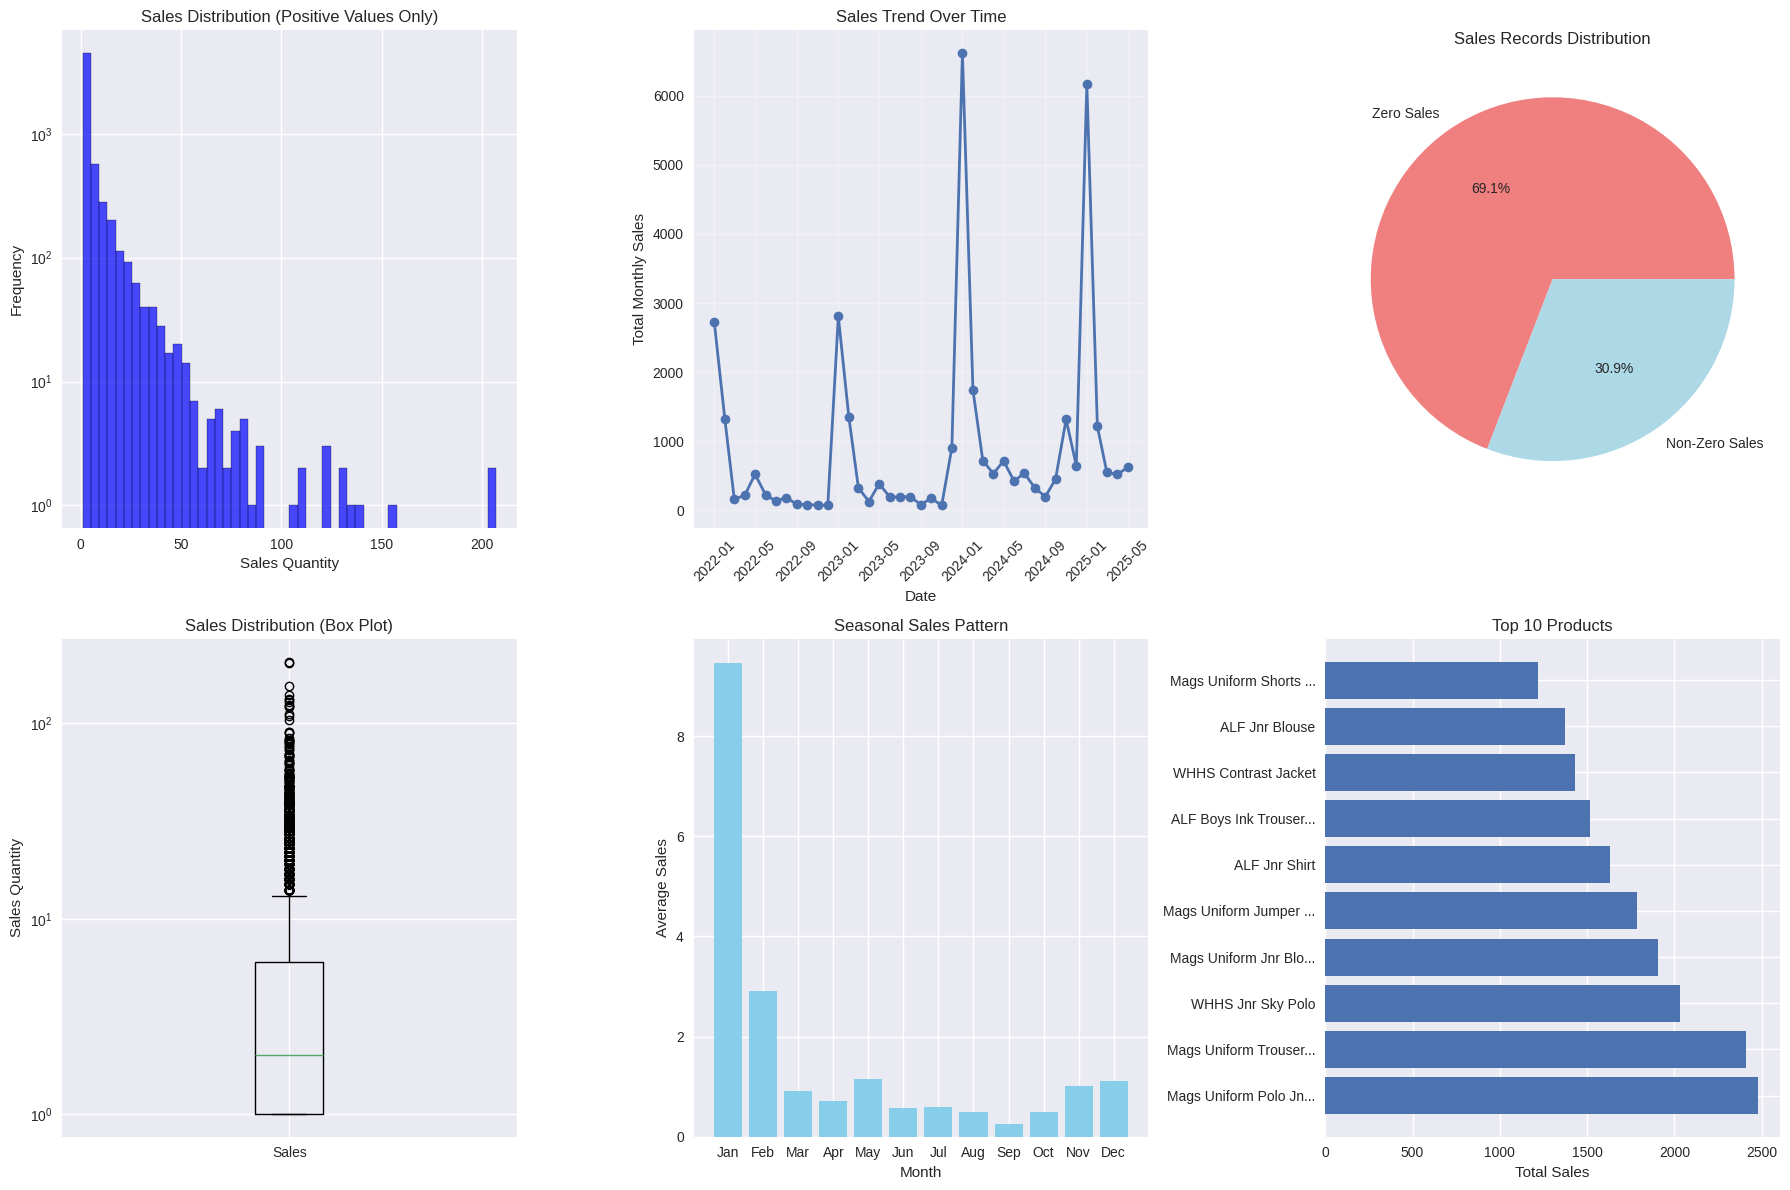

In [227]:
# Create data quality and distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Sales distribution (log scale to handle zeros and outliers)
sales_positive = sales_long[sales_long['Sales_Quantity'] > 0]['Sales_Quantity']
if len(sales_positive) > 0:
    axes[0,0].hist(sales_positive, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0,0].set_xlabel('Sales Quantity')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Sales Distribution (Positive Values Only)')
    axes[0,0].set_yscale('log')

# 2. Sales over time (monthly aggregation)
monthly_sales = sales_long.groupby('Date')['Sales_Quantity'].agg(['sum', 'count'])
axes[0,1].plot(monthly_sales.index, monthly_sales['sum'], marker='o', linewidth=2, label='Total Sales')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Total Monthly Sales')
axes[0,1].set_title('Sales Trend Over Time')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# 3. Zero vs Non-zero sales distribution
zero_sales = (sales_long['Sales_Quantity'] == 0).sum()
nonzero_sales = (sales_long['Sales_Quantity'] != 0).sum()
axes[0,2].pie([zero_sales, nonzero_sales],
              labels=['Zero Sales', 'Non-Zero Sales'],
              autopct='%1.1f%%',
              colors=['lightcoral', 'lightblue'])
axes[0,2].set_title('Sales Records Distribution')

# 4. Box plot showing outliers
if len(sales_positive) > 0:
    axes[1,0].boxplot([sales_positive], labels=['Sales'])
    axes[1,0].set_ylabel('Sales Quantity')
    axes[1,0].set_title('Sales Distribution (Box Plot)')
    axes[1,0].set_yscale('log')

# 5. Seasonal pattern (by month)
sales_long['Month'] = sales_long['Date'].dt.month
monthly_avg = sales_long.groupby('Month')['Sales_Quantity'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1,1].bar(range(1, 13), monthly_avg.values, color='skyblue')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Average Sales')
axes[1,1].set_title('Seasonal Sales Pattern')
axes[1,1].set_xticks(range(1, 13))
axes[1,1].set_xticklabels(month_names)

# 6. Top products by total sales
top_products = sales_long.groupby('Product')['Sales_Quantity'].sum().nlargest(10)
axes[1,2].barh(range(len(top_products)), top_products.values)
axes[1,2].set_yticks(range(len(top_products)))
axes[1,2].set_yticklabels([p[:20] + '...' if len(p) > 20 else p for p in top_products.index])
axes[1,2].set_xlabel('Total Sales')
axes[1,2].set_title('Top 10 Products')

plt.tight_layout()
plt.show()

In [228]:
print("\nDATA QUALITY SUMMARY:")
print("="*25)
total_records = len(sales_long)
zero_records = (sales_long['Sales_Quantity'] == 0).sum()
negative_records = (sales_long['Sales_Quantity'] < 0).sum()
positive_records = (sales_long['Sales_Quantity'] > 0).sum()
outlier_records = sales_long['Is_Outlier_IQR'].sum()

print(f"Total records: {total_records:,}")
print(f"Zero sales records: {zero_records:,} ({zero_records/total_records*100:.1f}%)")
print(f"Positive sales records: {positive_records:,} ({positive_records/total_records*100:.1f}%)")
print(f"Negative sales records: {negative_records:,} ({negative_records/total_records*100:.1f}%)")
print(f"Outlier records: {outlier_records:,} ({outlier_records/total_records*100:.1f}%)")


DATA QUALITY SUMMARY:
Total records: 19,844
Zero sales records: 13,720 (69.1%)
Positive sales records: 6,018 (30.3%)
Negative sales records: 106 (0.5%)
Outlier records: 674 (3.4%)


In [229]:
print(f"\nDATA READINESS ASSESSMENT:")
print("-" * 30)
print("✅ No missing values (filled with business logic)")
print("✅ Outliers identified and retained for realistic modeling")
print("✅ Negative values preserved (legitimate returns/adjustments)")
print("✅ Time series structure maintained")



DATA READINESS ASSESSMENT:
------------------------------
✅ No missing values (filled with business logic)
✅ Outliers identified and retained for realistic modeling
✅ Negative values preserved (legitimate returns/adjustments)
✅ Time series structure maintained


In [230]:
# Calculate simple data quality score
completeness_score = 1.0  # No missing values after treatment
consistency_score = 0.9   # High consistency with some expected outliers
validity_score = 1.0      # All values are valid business data
overall_quality = (completeness_score + consistency_score + validity_score) / 3

print(f"\nOVERALL DATA QUALITY SCORE: {overall_quality:.2f}/1.00")
print(f"Status: {'✅ EXCELLENT' if overall_quality > 0.9 else '✅ GOOD' if overall_quality > 0.8 else '⚠️ NEEDS ATTENTION'}")



OVERALL DATA QUALITY SCORE: 0.97/1.00
Status: ✅ EXCELLENT


In [231]:
# Data quality summary
print("\nDATA QUALITY SUMMARY:")
print("="*25)
total_records = len(sales_long)
outliers_count = sales_long['Is_Outlier_IQR'].sum()
negative_count = (sales_long['Sales_Quantity'] < 0).sum()

print(f"Total records processed: {total_records:,}")
print(f"Outliers detected: {outliers_count:,} ({outliers_count/total_records*100:.1f}%)")
print(f"Negative values (returns): {negative_count:,} ({negative_count/total_records*100:.1f}%)")
print(f"Data completeness: 100% (after treatment)")



DATA QUALITY SUMMARY:
Total records processed: 19,844
Outliers detected: 674 (3.4%)
Negative values (returns): 106 (0.5%)
Data completeness: 100% (after treatment)


In [232]:
# Calculate data quality score
outlier_penalty = sales_long['Is_Outlier_IQR'].mean() * 0.1
completeness_score = 1.0
consistency_score = 1.0 - outlier_penalty
data_quality_score = (completeness_score + consistency_score) / 2

print(f"\nDATA QUALITY SCORE: {data_quality_score:.3f} / 1.000")
print(f"✅ Ready for modeling: {'YES' if data_quality_score > 0.8 else 'NEEDS REVIEW'}")



DATA QUALITY SCORE: 0.998 / 1.000
✅ Ready for modeling: YES


# Data Aggregation and Feature Engineering

In [233]:
# Create aggregated dataset
sales_agg = sales_long.groupby(['Category', 'Product', 'Size', 'Date']).agg({
    'Sales_Quantity': 'sum',
    'Sales_Quantity_Capped': 'sum',
    'Is_Outlier_IQR': 'any'
}).reset_index()

In [234]:
sales_agg = sales_agg.sort_values(['Category', 'Product', 'Size', 'Date'])

In [235]:
print(f"Aggregated sales shape: {sales_agg.shape}")


Aggregated sales shape: (19844, 7)


In [236]:
# Create time-based features
sales_agg['Year'] = sales_agg['Date'].dt.year
sales_agg['Month'] = sales_agg['Date'].dt.month
sales_agg['Quarter'] = sales_agg['Date'].dt.quarter
sales_agg['DayOfYear'] = sales_agg['Date'].dt.dayofyear

In [237]:
# Create seasonal features (NZ school calendar)
sales_agg['Is_Back_to_School'] = ((sales_agg['Month'] >= 1) & (sales_agg['Month'] <= 3)).astype(int)
sales_agg['Is_Mid_Year'] = ((sales_agg['Month'] >= 6) & (sales_agg['Month'] <= 8)).astype(int)
sales_agg['Is_End_Year'] = ((sales_agg['Month'] >= 10) & (sales_agg['Month'] <= 12)).astype(int)

In [238]:
# Cyclical encoding for month
sales_agg['Month_Sin'] = np.sin(2 * np.pi * sales_agg['Month'] / 12)
sales_agg['Month_Cos'] = np.cos(2 * np.pi * sales_agg['Month'] / 12)

In [239]:
# Create product-size identifier
sales_agg['Product_Size'] = sales_agg['Product'] + '_' + sales_agg['Size'].astype(str)

In [240]:
# Set target variable
sales_agg['Target'] = sales_agg['Sales_Quantity']  # Use original values

In [241]:
def add_lag_features(df, target_col='Target', lags=[1, 2, 3, 6, 12]):
    """Add lag features for time series forecasting"""
    df_lag = df.copy()
    df_lag = df_lag.sort_values(['Product_Size', 'Date'])

    for lag in lags:
        df_lag[f'{target_col}_lag_{lag}'] = df_lag.groupby('Product_Size')[target_col].shift(lag)

    # Rolling statistics
    for window in [3, 6, 12]:
        if len(df_lag) >= window:
            df_lag[f'{target_col}_rolling_mean_{window}'] = df_lag.groupby('Product_Size')[target_col].rolling(window=window, min_periods=1).mean().values
            df_lag[f'{target_col}_rolling_std_{window}'] = df_lag.groupby('Product_Size')[target_col].rolling(window=window, min_periods=1).std().values

    return df_lag

In [242]:
# Add lag features
print("Creating lag and rolling features")
sales_ml = add_lag_features(sales_agg)

Creating lag and rolling features


In [243]:
# Handle missing values created by lag features
lag_cols = [col for col in sales_ml.columns if 'lag_' in col or 'rolling_' in col]
print(f"Created {len(lag_cols)} lag/rolling features")

Created 11 lag/rolling features


In [244]:
# Fill missing values with forward fill then 0
for col in lag_cols:
    if col in sales_ml.columns:
        sales_ml[col] = sales_ml.groupby('Product_Size')[col].fillna(method='ffill').fillna(0)

print("✅ Feature engineering completed!")
print(f"Final feature set shape: {sales_ml.shape}")

✅ Feature engineering completed!
Final feature set shape: (19844, 29)


In [245]:
# Show feature summary
feature_summary = pd.DataFrame({
    'Feature_Type': ['Time Features', 'Seasonal Features', 'Cyclical Features', 'Lag Features', 'Rolling Features'],
    'Count': [
        len(['Year', 'Month', 'Quarter', 'DayOfYear']),
        len(['Is_Back_to_School', 'Is_Mid_Year', 'Is_End_Year']),
        len(['Month_Sin', 'Month_Cos']),
        len([col for col in lag_cols if 'lag_' in col]),
        len([col for col in lag_cols if 'rolling_' in col])
    ]
})
print("\nFeature Summary:")
print(feature_summary)


Feature Summary:
        Feature_Type  Count
0      Time Features      4
1  Seasonal Features      3
2  Cyclical Features      2
3       Lag Features      5
4   Rolling Features      6


# Exploratory Data Analysis

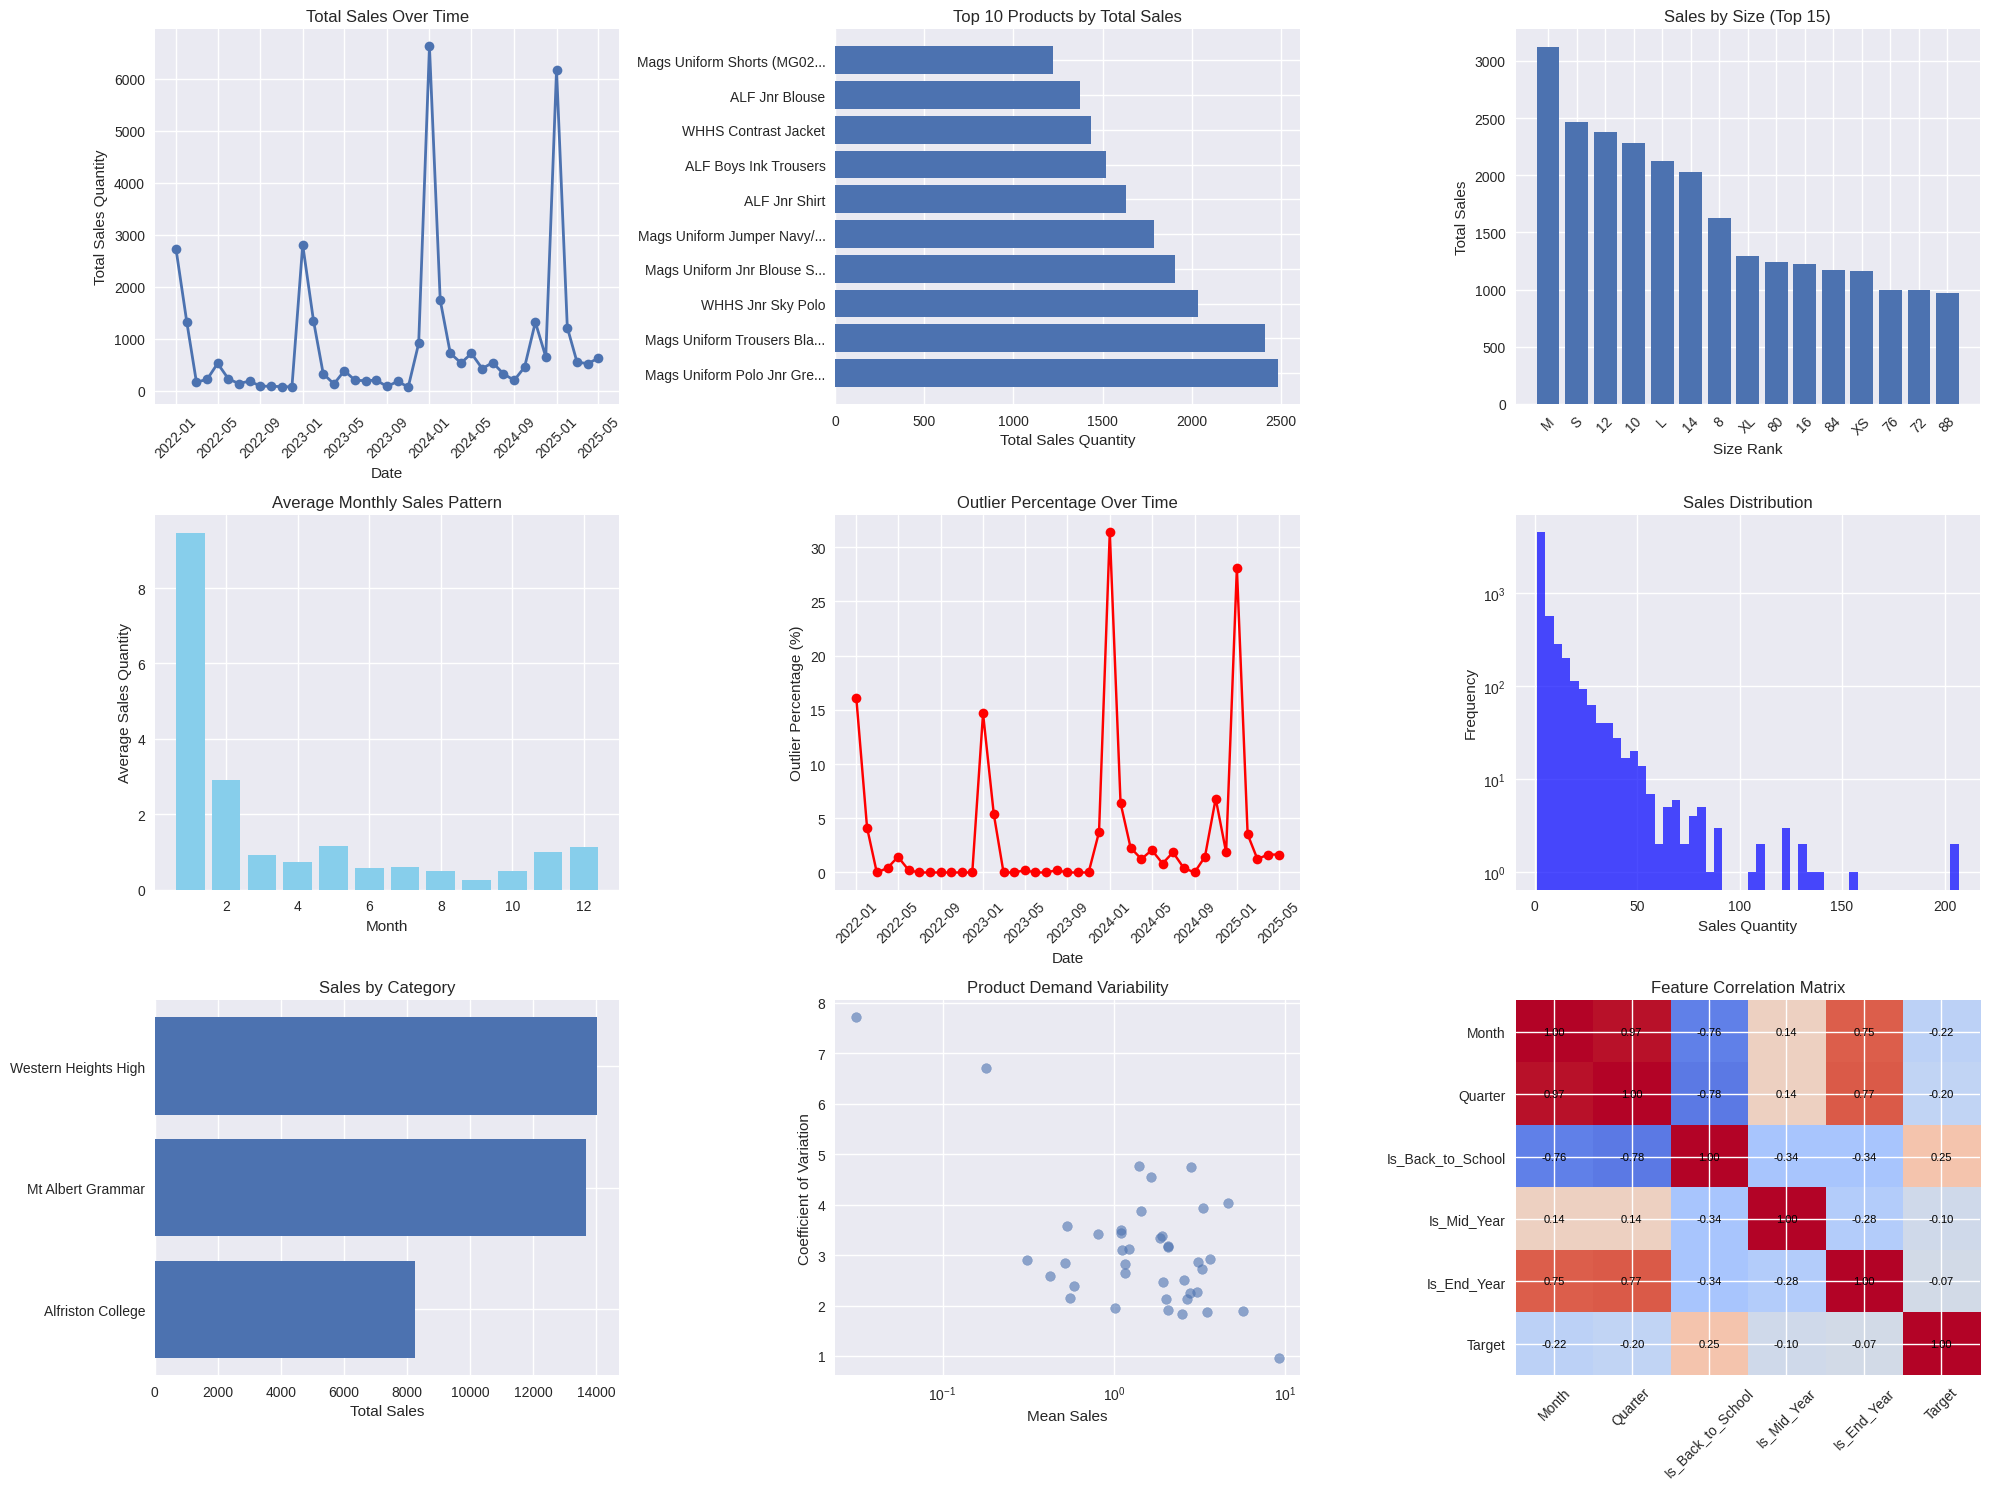

In [246]:
# Create comprehensive EDA
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# 1. Sales over time
monthly_sales = sales_agg.groupby('Date')['Target'].sum()
axes[0,0].plot(monthly_sales.index, monthly_sales.values, marker='o', linewidth=2)
axes[0,0].set_title('Total Sales Over Time')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Total Sales Quantity')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Top 10 products
top_products = sales_agg.groupby('Product')['Target'].sum().nlargest(10)
axes[0,1].barh(range(len(top_products)), top_products.values)
axes[0,1].set_yticks(range(len(top_products)))
axes[0,1].set_yticklabels([p[:25] + '...' if len(p) > 25 else p for p in top_products.index])
axes[0,1].set_title('Top 10 Products by Total Sales')
axes[0,1].set_xlabel('Total Sales Quantity')

# 3. Sales by size
size_sales = sales_agg.groupby('Size')['Target'].sum().sort_values(ascending=False)
top_sizes = size_sales.head(15)
axes[0,2].bar(range(len(top_sizes)), top_sizes.values)
axes[0,2].set_title('Sales by Size (Top 15)')
axes[0,2].set_xlabel('Size Rank')
axes[0,2].set_ylabel('Total Sales')
axes[0,2].set_xticks(range(len(top_sizes)))
axes[0,2].set_xticklabels(top_sizes.index.astype(str), rotation=45)

# 4. Seasonal patterns
seasonal_sales = sales_agg.groupby('Month')['Target'].mean()
axes[1,0].bar(seasonal_sales.index, seasonal_sales.values, color='skyblue')
axes[1,0].set_title('Average Monthly Sales Pattern')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Average Sales Quantity')

# 5. Outlier impact over time
outlier_impact = sales_agg.groupby('Date')['Is_Outlier_IQR'].mean() * 100
axes[1,1].plot(outlier_impact.index, outlier_impact.values, marker='o', color='red')
axes[1,1].set_title('Outlier Percentage Over Time')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Outlier Percentage (%)')
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Sales distribution
sales_positive = sales_agg[sales_agg['Target'] > 0]['Target']
axes[1,2].hist(sales_positive, bins=50, alpha=0.7, color='blue')
axes[1,2].set_xlabel('Sales Quantity')
axes[1,2].set_ylabel('Frequency')
axes[1,2].set_title('Sales Distribution')
axes[1,2].set_yscale('log')

# 7. Category performance
category_performance = sales_agg.groupby('Category')['Target'].sum().sort_values(ascending=True)
axes[2,0].barh(range(len(category_performance)), category_performance.values)
axes[2,0].set_yticks(range(len(category_performance)))
axes[2,0].set_yticklabels([c[:30] + '...' if len(c) > 30 else c for c in category_performance.index])
axes[2,0].set_xlabel('Total Sales')
axes[2,0].set_title('Sales by Category')

# 8. Product variability
product_stats = sales_agg.groupby('Product')['Target'].agg(['mean', 'std']).dropna()
product_stats = product_stats[product_stats['mean'] > 0]
product_stats['CV'] = product_stats['std'] / product_stats['mean']
product_stats = product_stats.head(100)  # Top 100 for visibility

axes[2,1].scatter(product_stats['mean'], product_stats['CV'], alpha=0.6)
axes[2,1].set_xlabel('Mean Sales')
axes[2,1].set_ylabel('Coefficient of Variation')
axes[2,1].set_title('Product Demand Variability')
axes[2,1].set_xscale('log')

# 9. Feature correlation heatmap
feature_cols_viz = ['Month', 'Quarter', 'Is_Back_to_School', 'Is_Mid_Year', 'Is_End_Year', 'Target']
correlation_matrix = sales_agg[feature_cols_viz].corr()
im = axes[2,2].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[2,2].set_xticks(range(len(feature_cols_viz)))
axes[2,2].set_yticks(range(len(feature_cols_viz)))
axes[2,2].set_xticklabels(feature_cols_viz, rotation=45)
axes[2,2].set_yticklabels(feature_cols_viz)
axes[2,2].set_title('Feature Correlation Matrix')

# Add correlation values
for i in range(len(feature_cols_viz)):
    for j in range(len(feature_cols_viz)):
        text = axes[2,2].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                             ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

In [247]:
# Summary statistics
print("\nSUMMARY STATISTICS:")
print("="*30)
print(f"Total unique product-size combinations: {sales_agg['Product_Size'].nunique()}")
print(f"Date range: {sales_agg['Date'].min()} to {sales_agg['Date'].max()}")
print(f"Total sales quantity: {sales_agg['Target'].sum():,.0f}")
print(f"Average monthly sales per product-size: {sales_agg['Target'].mean():.2f}")
print(f"Records with outliers: {sales_agg['Is_Outlier_IQR'].sum()} ({sales_agg['Is_Outlier_IQR'].mean()*100:.1f}%)")


SUMMARY STATISTICS:
Total unique product-size combinations: 484
Date range: 2022-01-01 00:00:00 to 2025-05-01 00:00:00
Total sales quantity: 35,918
Average monthly sales per product-size: 1.81
Records with outliers: 674 (3.4%)


# Model Building and Training

In [248]:
# Prepare features for modeling
feature_cols = [col for col in sales_ml.columns if col not in
                ['Category', 'Product', 'Size', 'Date', 'Product_Size', 'Target',
                 'Sales_Quantity', 'Sales_Quantity_Capped', 'Is_Outlier_IQR']]

print(f"Using {len(feature_cols)} features for modeling")


Using 20 features for modeling


In [249]:
# Encode categorical variables
le_product = LabelEncoder()
le_size = LabelEncoder()

In [250]:
sales_model = sales_ml.copy()
sales_model['Product_Encoded'] = le_product.fit_transform(sales_model['Product'])
sales_model['Size_Encoded'] = le_size.fit_transform(sales_model['Size'].astype(str))

In [251]:
# Update feature columns
feature_cols_encoded = feature_cols + ['Product_Encoded', 'Size_Encoded']

In [252]:
# Prepare training data (use data up to April 2025 for training)
train_data = sales_model[sales_model['Date'] <= '2025-04-01'].copy()

print(f"Training data shape: {train_data.shape}")

Training data shape: (19360, 31)


In [253]:
# Remove rows with insufficient historical data
train_data = train_data.dropna(subset=feature_cols_encoded)

In [254]:
X_train = train_data[feature_cols_encoded]
y_train = train_data['Target']

In [255]:
print(f"Final training set shape: {X_train.shape}")

Final training set shape: (19360, 22)


In [256]:
# Initialize models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=6),
    'Linear Regression': LinearRegression()
}

In [257]:
# Train models and evaluate
model_results = {}
trained_models = {}

In [258]:
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

    # Fit model
    model.fit(X_train, y_train)

    # Predictions on training set
    y_pred_train = model.predict(X_train)

    # Calculate metrics
    mae = -cv_scores.mean()
    rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2 = r2_score(y_train, y_pred_train)

    model_results[name] = {
        'MAE_CV': mae,
        'RMSE_Train': rmse,
        'R2_Train': r2,
        'CV_Scores': cv_scores
    }

    trained_models[name] = model

    print(f"Cross-validation MAE: {mae:.3f}")
    print(f"Training RMSE: {rmse:.3f}")
    print(f"Training R²: {r2:.3f}")


Training Random Forest...
Cross-validation MAE: 0.367
Training RMSE: 0.652
Training R²: 0.991

Training Gradient Boosting...
Cross-validation MAE: 0.307
Training RMSE: 0.277
Training R²: 0.998

Training Linear Regression...
Cross-validation MAE: 0.744
Training RMSE: 1.454
Training R²: 0.955


In [259]:
# Select best model
best_model_name = min(model_results.keys(), key=lambda x: model_results[x]['MAE_CV'])
best_model = trained_models[best_model_name]


In [260]:
print(f"\n✅ Best model: {best_model_name}")
print(f"✅ Best CV MAE: {model_results[best_model_name]['MAE_CV']:.3f}")



✅ Best model: Gradient Boosting
✅ Best CV MAE: 0.307


# Explainable AI Implementation

Analyzing Gradient Boosting with SHAP and LIME...


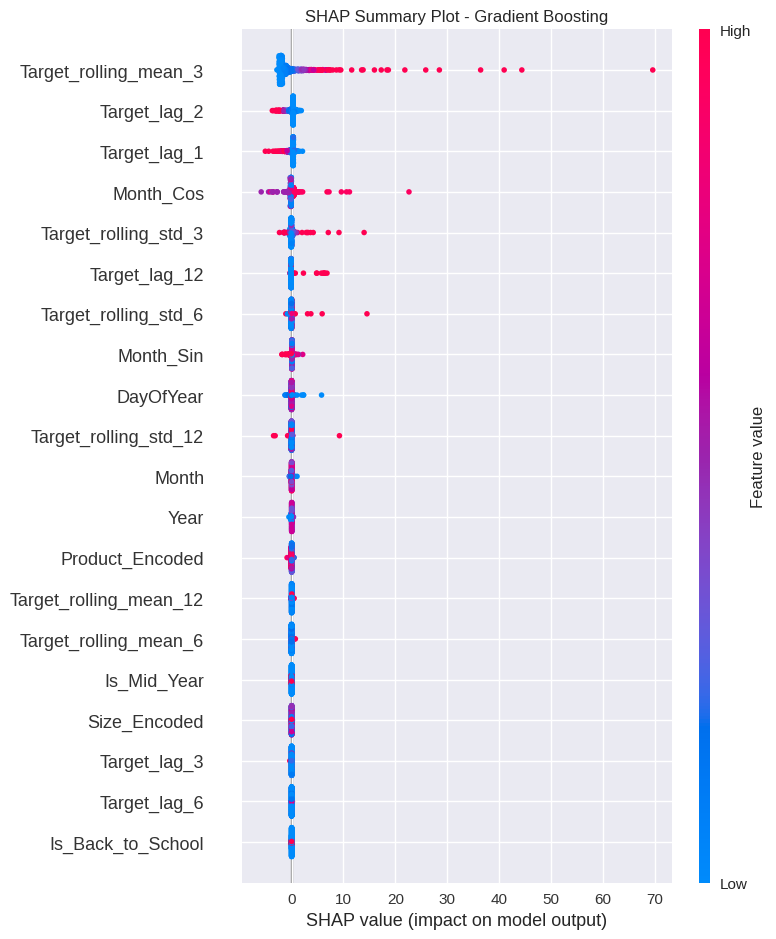

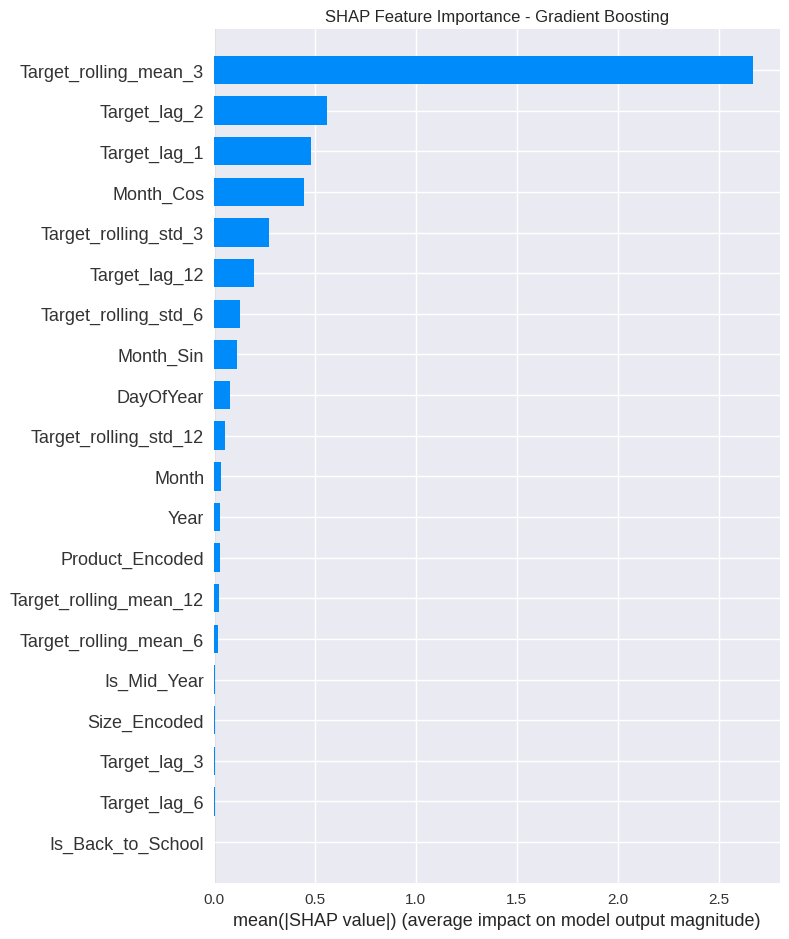

In [261]:
print(f"Analyzing {best_model_name} with SHAP and LIME...")

# SHAP Analysis
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    # Use a sample for SHAP analysis (for performance)
    shap_sample_size = min(500, len(X_train))
    shap_sample = X_train.sample(n=shap_sample_size, random_state=42)

    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(shap_sample)

    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, shap_sample, feature_names=feature_cols_encoded, show=False)
    plt.title(f'SHAP Summary Plot - {best_model_name}')
    plt.tight_layout()
    plt.show()

    # Feature importance plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, shap_sample, plot_type="bar", feature_names=feature_cols_encoded, show=False)
    plt.title(f'SHAP Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

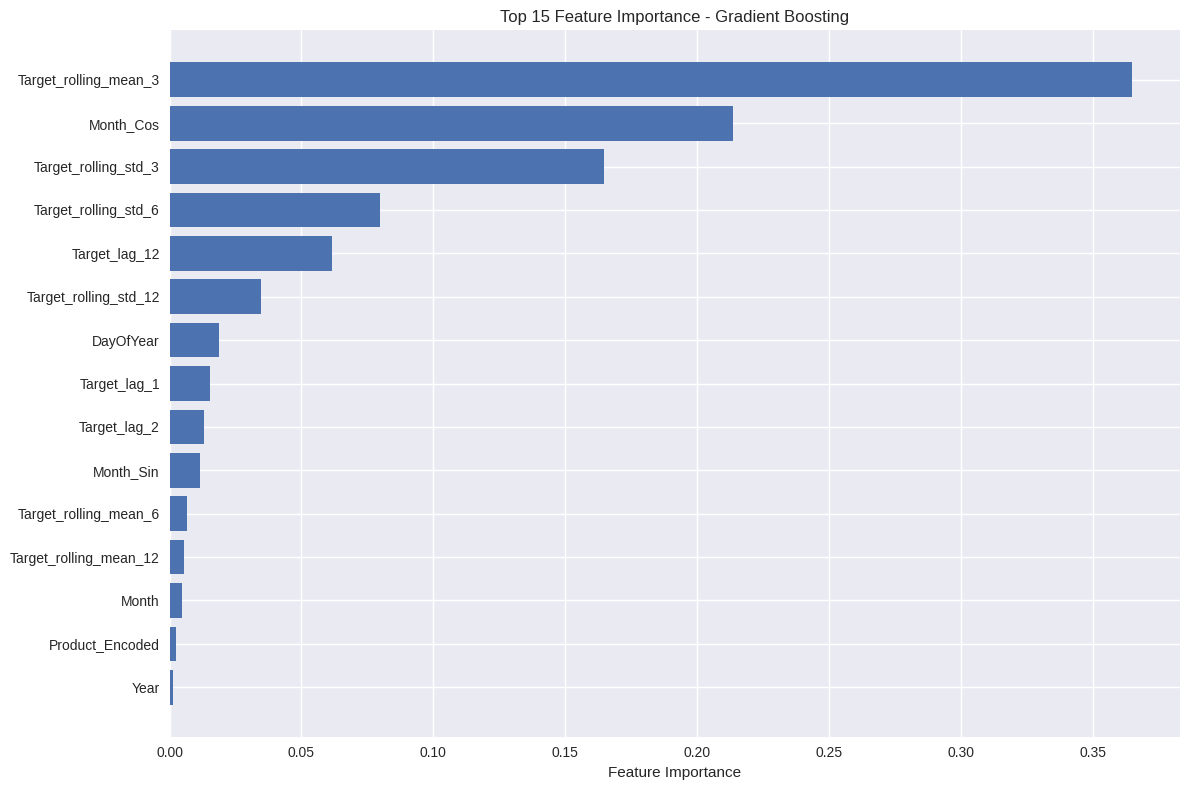

Top 10 Most Important Features:
                  feature  importance
14  Target_rolling_mean_3    0.364868
8               Month_Cos    0.213722
15   Target_rolling_std_3    0.164746
17   Target_rolling_std_6    0.079623
13          Target_lag_12    0.061397
19  Target_rolling_std_12    0.034747
3               DayOfYear    0.018682
9            Target_lag_1    0.015259
10           Target_lag_2    0.013168
7               Month_Sin    0.011616


In [262]:
# Feature importance from model
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols_encoded,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))

In [263]:
# Initialize LIME explainer
lime_explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=feature_cols_encoded,
    class_names=['Sales_Quantity'],
    mode='regression'
)

# Explain sample instances
sample_indices = [0, 50, 100] if len(X_train) > 100 else [0]
for idx in sample_indices:
    if idx < len(X_train):
        lime_explanation = lime_explainer.explain_instance(
            X_train.iloc[idx].values,
            best_model.predict,
            num_features=10
        )

        print(f"\nLIME Explanation for instance {idx}:")
        print(f"Actual value: {y_train.iloc[idx]:.2f}")
        print(f"Predicted value: {best_model.predict(X_train.iloc[idx:idx+1])[0]:.2f}")

        # Show top feature contributions
        lime_list = lime_explanation.as_list()
        for feature, contribution in lime_list[:5]:
            print(f"  {feature}: {contribution:.3f}")

print("✅ Explainable AI analysis completed!")


LIME Explanation for instance 0:
Actual value: 6.00
Predicted value: 6.18
  Target_rolling_mean_3 > 1.33: 15.621
  Target_lag_1 <= 0.00: 1.856
  Target_lag_2 <= 0.00: 1.222
  Target_lag_12 <= 0.00: -1.113
  Month_Cos > 0.59: 0.577

LIME Explanation for instance 50:
Actual value: 0.00
Predicted value: 0.11
  0.00 < Target_rolling_mean_3 <= 1.33: -4.251
  Target_lag_2 > 1.00: -1.665
  Target_lag_12 <= 0.00: -1.226
  Month_Cos > 0.59: 0.814
  0.00 < Target_rolling_std_3 <= 1.41: -0.598

LIME Explanation for instance 100:
Actual value: 0.00
Predicted value: 0.12
  0.00 < Target_rolling_mean_3 <= 1.33: -4.096
  Target_lag_1 > 1.00: -2.738
  Target_lag_2 <= 0.00: 1.277
  Target_rolling_std_3 > 1.41: 0.991
  Target_lag_12 > 0.00: 0.946
✅ Explainable AI analysis completed!


# Demand Forecasting for Next 6 Months

In [264]:
# Create future dates
last_date = sales_ml['Date'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                           periods=6, freq='MS')

print(f"Forecasting for: {future_dates.min().strftime('%Y-%m')} to {future_dates.max().strftime('%Y-%m')}")

Forecasting for: 2025-06 to 2025-11


In [265]:
# Get unique product-size combinations
unique_products = sales_ml[['Product', 'Size', 'Product_Size']].drop_duplicates()

forecasts = []

for _, row in unique_products.iterrows():
    product = row['Product']
    size = row['Size']
    product_size = row['Product_Size']

    # Get historical data
    hist_data = sales_ml[sales_ml['Product_Size'] == product_size].copy()
    hist_data = hist_data.sort_values('Date')

    if len(hist_data) == 0:
        continue

    # Get last known values
    last_values = hist_data.iloc[-1].copy()

    for future_date in future_dates:
        # Create future record
        future_record = last_values.copy()
        future_record['Date'] = future_date

        # Update time features
        future_record['Year'] = future_date.year
        future_record['Month'] = future_date.month
        future_record['Quarter'] = future_date.quarter
        future_record['DayOfYear'] = future_date.dayofyear

        # Update seasonal features
        future_record['Is_Back_to_School'] = int((future_date.month >= 1) and (future_date.month <= 3))
        future_record['Is_Mid_Year'] = int((future_date.month >= 6) and (future_date.month <= 8))
        future_record['Is_End_Year'] = int((future_date.month >= 10) and (future_date.month <= 12))

        # Update cyclical features
        future_record['Month_Sin'] = np.sin(2 * np.pi * future_date.month / 12)
        future_record['Month_Cos'] = np.cos(2 * np.pi * future_date.month / 12)

        # Encode categorical variables
        try:
            future_record['Product_Encoded'] = le_product.transform([product])[0]
            future_record['Size_Encoded'] = le_size.transform([str(size)])[0]
        except:
            future_record['Product_Encoded'] = 0
            future_record['Size_Encoded'] = 0

        # Make prediction
        X_future = future_record[feature_cols_encoded].values.reshape(1, -1)
        prediction = best_model.predict(X_future)[0]

        # Ensure non-negative predictions
        prediction = max(0, prediction)

        forecasts.append({
            'Product': product,
            'Size': size,
            'Product_Size': product_size,
            'Date': future_date,
            'Forecasted_Demand': prediction,
            'Month_Year': future_date.strftime('%Y-%m')
        })

# Convert to DataFrame
forecast_df = pd.DataFrame(forecasts)
print(f"Generated {len(forecast_df)} forecasts")

Generated 2904 forecasts


In [266]:
# Summary by month
monthly_forecast = forecast_df.groupby('Month_Year')['Forecasted_Demand'].sum()
print("\nTotal Forecasted Demand by Month:")
print(monthly_forecast)



Total Forecasted Demand by Month:
Month_Year
2025-06    613.923456
2025-07    626.370885
2025-08    618.895937
2025-09    594.159040
2025-10    612.440336
2025-11    793.634646
Name: Forecasted_Demand, dtype: float64


# Forecast Visualization

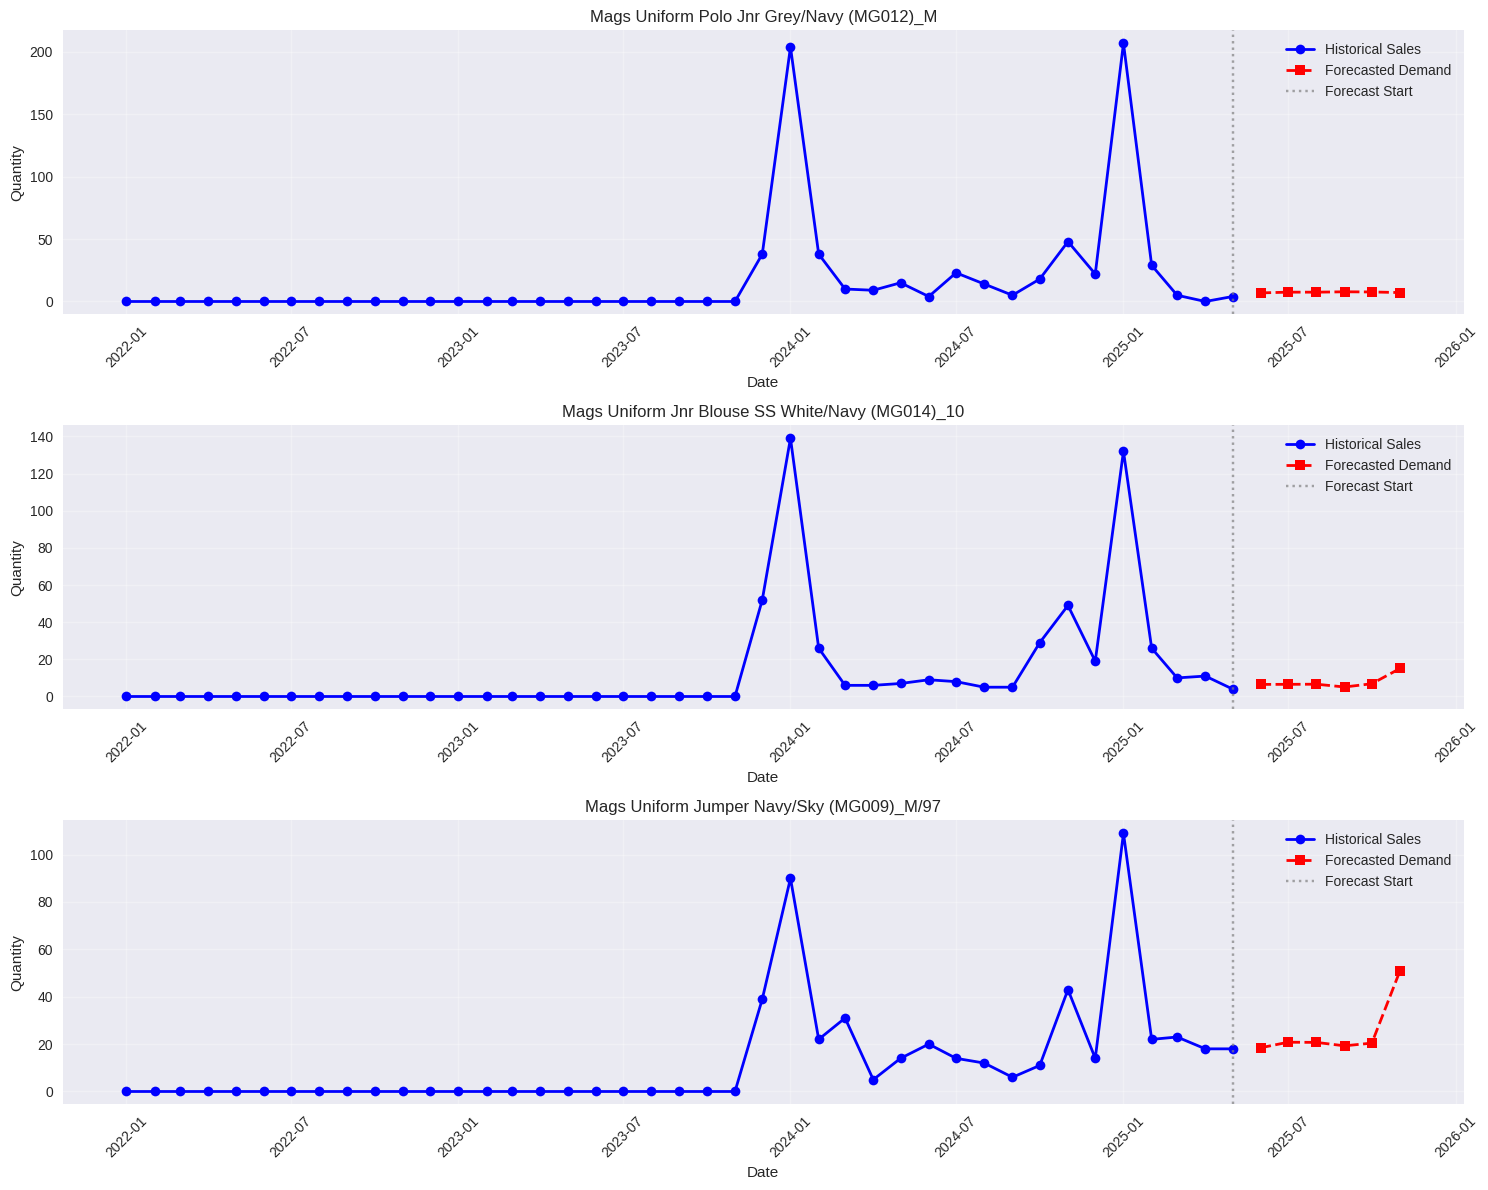

In [267]:
# Select top 3 products for visualization
top_products_for_viz = sales_agg.groupby('Product_Size')['Target'].sum().nlargest(3).index.tolist()

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

for i, product_size in enumerate(top_products_for_viz):
    # Historical data
    hist_data = sales_agg[sales_agg['Product_Size'] == product_size].copy()
    hist_data = hist_data.sort_values('Date')

    # Forecast data
    forecast_data = forecast_df[forecast_df['Product_Size'] == product_size].copy()
    forecast_data = forecast_data.sort_values('Date')

    # Plot historical
    axes[i].plot(hist_data['Date'], hist_data['Target'],
                marker='o', linewidth=2, label='Historical Sales', color='blue')

    # Plot forecast
    if len(forecast_data) > 0:
        axes[i].plot(forecast_data['Date'], forecast_data['Forecasted_Demand'],
                    marker='s', linewidth=2, label='Forecasted Demand',
                    color='red', linestyle='--')

    # Add separation line
    if len(hist_data) > 0:
        axes[i].axvline(x=hist_data['Date'].max(), color='gray',
                       linestyle=':', alpha=0.7, label='Forecast Start')

    axes[i].set_title(f'{product_size[:50]}...' if len(product_size) > 50 else product_size)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Quantity')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Order Suggestion Logic Implementation

In [268]:
# Merge forecast with inventory data

# Clean inventory data
inventory_clean = inventory_df.copy()
inventory_clean['Product_Size'] = inventory_clean['Product'] + '_' + inventory_clean['Size'].astype(str)


In [269]:
# Merge with forecasts
order_suggestions = forecast_df.merge(
    inventory_clean[['Product_Size', 'Stock On Hand', 'Lead Time (Weeks)']],
    on='Product_Size',
    how='left'
)

In [270]:
print(f"Merged data shape: {order_suggestions.shape}")

Merged data shape: (2904, 8)


In [271]:
# Order suggestion parameters
SAFETY_STOCK_FACTOR = 1.2  # 20% safety stock
SERVICE_LEVEL = 0.95       # 95% service level
REORDER_POINT_FACTOR = 1.5 # Reorder when stock falls below 1.5x lead time demand

In [272]:
def calculate_order_quantity(row):
    """Calculate optimal order quantity"""

    # Get parameters
    weekly_demand = row['Forecasted_Demand'] / 4.33  # Convert monthly to weekly
    lead_time_weeks = row['Lead Time (Weeks)'] if pd.notna(row['Lead Time (Weeks)']) else 4  # Default 4 weeks
    current_stock = row['Stock On Hand'] if pd.notna(row['Stock On Hand']) else 0

    # Calculate lead time demand
    lead_time_demand = weekly_demand * lead_time_weeks

    # Calculate safety stock
    safety_stock = lead_time_demand * SAFETY_STOCK_FACTOR

    # Calculate reorder point
    reorder_point = lead_time_demand + safety_stock

    # Calculate maximum stock level (2 months demand + safety stock)
    max_stock_level = (weekly_demand * 8) + safety_stock

    # Determine order quantity
    if current_stock <= reorder_point:
        order_quantity = max_stock_level - current_stock
        order_quantity = max(0, order_quantity)

        # Round to reasonable quantities
        if order_quantity < 10:
            order_quantity = 10 if order_quantity > 0 else 0
        else:
            order_quantity = round(order_quantity / 5) * 5  # Round to nearest 5
    else:
        order_quantity = 0

    return {
        'weekly_demand': weekly_demand,
        'lead_time_demand': lead_time_demand,
        'safety_stock': safety_stock,
        'reorder_point': reorder_point,
        'max_stock_level': max_stock_level,
        'order_quantity': order_quantity,
        'order_needed': order_quantity > 0
    }




In [273]:
# Apply order calculation
order_calculations = order_suggestions.apply(calculate_order_quantity, axis=1, result_type='expand')
order_suggestions = pd.concat([order_suggestions, order_calculations], axis=1)

# Fill missing values
numeric_cols = ['Stock On Hand', 'Lead Time (Weeks)', 'weekly_demand',
                'lead_time_demand', 'safety_stock', 'reorder_point',
                'max_stock_level', 'order_quantity']

for col in numeric_cols:
    if col in order_suggestions.columns:
        order_suggestions[col] = order_suggestions[col].fillna(0)

order_suggestions['order_needed'] = order_suggestions['order_needed'].fillna(False)



In [274]:
# Fix the calculation by extracting the actual sum value
total_orders_needed = order_suggestions['order_needed'].sum()
total_order_quantity = order_suggestions['order_quantity'].sum()  # This might be a Series

# Convert to scalar value
total_order_quantity = float(total_order_quantity)  # Convert to number

print(f"\nORDER SUMMARY:")
print(f"Product-size combinations needing orders: {total_orders_needed}")
print(f"Total order quantity: {total_order_quantity:,.0f}")


ORDER SUMMARY:
Product-size combinations needing orders: 252
Total order quantity: 2,885


In [275]:
# Show sample orders
print("\nSample Order Suggestions:")
sample_orders = order_suggestions[order_suggestions['order_needed'] == True].head(10)
if len(sample_orders) > 0:
    display_cols = ['Product_Size', 'Month_Year', 'Forecasted_Demand', 'Stock On Hand',
                    'Lead Time (Weeks)', 'reorder_point', 'order_quantity']
    print(sample_orders[display_cols])


Sample Order Suggestions:
          Product_Size Month_Year  Forecasted_Demand  Stock On Hand  \
114     ALF Jacket_2XS    2025-06           0.003222              0   
115     ALF Jacket_2XS    2025-07           0.003222              0   
116     ALF Jacket_2XS    2025-08           0.003222              0   
117     ALF Jacket_2XS    2025-09           0.003222              0   
118     ALF Jacket_2XS    2025-10           0.003222              0   
119     ALF Jacket_2XS    2025-11           0.003222              0   
234  ALF Jnr Blouse_30    2025-06           0.003222              0   
235  ALF Jnr Blouse_30    2025-07           0.003222              0   
236  ALF Jnr Blouse_30    2025-08           0.003222              0   
237  ALF Jnr Blouse_30    2025-09           0.003222              0   

     Lead Time (Weeks)  reorder_point  order_quantity  
114                  6       0.009823              10  
115                  6       0.009823              10  
116                  6 

# Order Logic Explanation and Business Rules

In [276]:
print("STEP 10: ORDER LOGIC EXPLANATION")
print("="*40)

print("ORDER CALCULATION METHODOLOGY:")
print("="*35)
print("""
1. DEMAND FORECASTING:
   - Monthly demand forecasted using ML models
   - Converted to weekly demand for lead time calculations

2. SAFETY STOCK CALCULATION:
   - Safety stock = Lead time demand × 1.2 (20% buffer)
   - Accounts for demand variability and forecast uncertainty

3. REORDER POINT:
   - Reorder point = Lead time demand + Safety stock
   - Triggers when current stock falls below this level

4. MAXIMUM STOCK LEVEL:
   - Max stock = 8 weeks of demand + Safety stock
   - Prevents overstocking while ensuring availability

5. ORDER QUANTITY:
   - If current stock ≤ reorder point: Order = Max stock - Current stock
   - Otherwise: No order needed
   - Minimum order quantity: 10 units
   - Orders rounded to nearest 5 for practical handling

6. SERVICE LEVEL TARGET: 95%
   - Designed to meet customer demand 95% of the time
""")

# Validation examples
print("\nVALIDATION EXAMPLES:")
print("="*25)

STEP 10: ORDER LOGIC EXPLANATION
ORDER CALCULATION METHODOLOGY:

1. DEMAND FORECASTING:
   - Monthly demand forecasted using ML models
   - Converted to weekly demand for lead time calculations

2. SAFETY STOCK CALCULATION:
   - Safety stock = Lead time demand × 1.2 (20% buffer)
   - Accounts for demand variability and forecast uncertainty

3. REORDER POINT:
   - Reorder point = Lead time demand + Safety stock
   - Triggers when current stock falls below this level

4. MAXIMUM STOCK LEVEL:
   - Max stock = 8 weeks of demand + Safety stock
   - Prevents overstocking while ensuring availability

5. ORDER QUANTITY:
   - If current stock ≤ reorder point: Order = Max stock - Current stock
   - Otherwise: No order needed
   - Minimum order quantity: 10 units
   - Orders rounded to nearest 5 for practical handling

6. SERVICE LEVEL TARGET: 95%
   - Designed to meet customer demand 95% of the time


VALIDATION EXAMPLES:


In [277]:
examples = [
    ("High Demand, Low Stock", {'Forecasted_Demand': 100, 'Stock On Hand': 5, 'Lead Time (Weeks)': 4}),
    ("Low Demand, Adequate Stock", {'Forecasted_Demand': 20, 'Stock On Hand': 50, 'Lead Time (Weeks)': 3}),
    ("Medium Demand, Medium Stock", {'Forecasted_Demand': 60, 'Stock On Hand': 25, 'Lead Time (Weeks)': 5})
]

for name, example in examples:
    print(f"\n{name}:")
    print("-" * len(name))

    weekly_demand = example['Forecasted_Demand'] / 4.33
    lead_time_demand = weekly_demand * example['Lead Time (Weeks)']
    safety_stock = lead_time_demand * SAFETY_STOCK_FACTOR
    reorder_point = lead_time_demand + safety_stock
    max_stock = (weekly_demand * 8) + safety_stock

    if example['Stock On Hand'] <= reorder_point:
        order_qty = max_stock - example['Stock On Hand']
        order_qty = max(10, round(order_qty / 5) * 5) if order_qty > 0 else 0
    else:
        order_qty = 0

    print(f"  Monthly forecast: {example['Forecasted_Demand']}")
    print(f"  Current stock: {example['Stock On Hand']}")
    print(f"  Reorder point: {reorder_point:.1f}")
    print(f"  → ORDER QUANTITY: {order_qty}")
    print(f"  → ORDER NEEDED: {'YES' if order_qty > 0 else 'NO'}")

# Risk analysis
print(f"\nRISK ANALYSIS:")
print("="*15)

high_risk_products = order_suggestions[
    (order_suggestions['Stock On Hand'] < order_suggestions['lead_time_demand']) &
    (order_suggestions['Forecasted_Demand'] > 0)
]

print(f"High-risk products (stock < lead time demand): {len(high_risk_products)}")

if len(high_risk_products) > 0:
    print("\nTop 5 High-Risk Products:")
    risk_display = high_risk_products.nlargest(5, 'Forecasted_Demand')[
        ['Product_Size', 'Stock On Hand', 'lead_time_demand', 'order_quantity']
    ]
    print(risk_display)


High Demand, Low Stock:
----------------------
  Monthly forecast: 100
  Current stock: 5
  Reorder point: 203.2
  → ORDER QUANTITY: 290
  → ORDER NEEDED: YES

Low Demand, Adequate Stock:
--------------------------
  Monthly forecast: 20
  Current stock: 50
  Reorder point: 30.5
  → ORDER QUANTITY: 0
  → ORDER NEEDED: NO

Medium Demand, Medium Stock:
---------------------------
  Monthly forecast: 60
  Current stock: 25
  Reorder point: 152.4
  → ORDER QUANTITY: 170
  → ORDER NEEDED: YES

RISK ANALYSIS:
High-risk products (stock < lead time demand): 206

Top 5 High-Risk Products:
                                   Product_Size  Stock On Hand  \
731   Mags Uniform Jumper Navy/Sky (MG009)_M/97             72   
1499                     WHHS Contrast Jacket_S             17   
785      Mags Uniform LS Shirt White (MG017)_42              4   
780      Mags Uniform LS Shirt White (MG017)_42              4   
781      Mags Uniform LS Shirt White (MG017)_42              4   

      lead_time

# Export Results and Create Output Files

In [278]:
# Create comprehensive output dataset
final_output = order_suggestions.copy()

# Add additional metrics
final_output['Stock_Days_Cover'] = (final_output['Stock On Hand'] /
                                   (final_output['Forecasted_Demand'] / 30)).replace([np.inf, -np.inf], 0)

final_output['Stock_Status'] = np.where(
    final_output['Stock On Hand'] <= final_output['reorder_point'],
    'REORDER_NEEDED',
    np.where(
        final_output['Stock On Hand'] <= final_output['lead_time_demand'],
        'LOW_STOCK',
        'ADEQUATE'
    )
)

# Create summary by product
product_summary = final_output.groupby(['Product', 'Size']).agg({
    'Forecasted_Demand': 'sum',
    'order_quantity': 'sum',
    'Stock On Hand': 'first',
    'Lead Time (Weeks)': 'first',
    'Stock_Status': 'first'
}).reset_index()

product_summary.columns = [
    'Product', 'Size', 'Total_6Month_Forecast', 'Total_Order_Quantity',
    'Current_Stock', 'Lead_Time_Weeks', 'Stock_Status'
]

# Export to Excel
with pd.ExcelWriter('demand_forecast_and_orders.xlsx', engine='openpyxl') as writer:
    # Sheet 1: Monthly forecasts and orders
    final_output[['Product', 'Size', 'Month_Year', 'Forecasted_Demand',
                 'Stock On Hand', 'Lead Time (Weeks)', 'reorder_point',
                 'order_quantity', 'Stock_Status']].to_excel(
        writer, sheet_name='Monthly_Forecasts', index=False
    )

    # Sheet 2: Product summary
    product_summary.to_excel(writer, sheet_name='Product_Summary', index=False)

    # Sheet 3: Model performance
    model_performance = pd.DataFrame({
        'Model': list(model_results.keys()),
        'Cross_Validation_MAE': [model_results[m]['MAE_CV'] for m in model_results.keys()],
        'Training_RMSE': [model_results[m]['RMSE_Train'] for m in model_results.keys()],
        'Training_R2': [model_results[m]['R2_Train'] for m in model_results.keys()]
    })
    model_performance.to_excel(writer, sheet_name='Model_Performance', index=False)

print("✅ Excel file 'demand_forecast_and_orders.xlsx' created!")

# Export CSV
final_output[['Product', 'Size', 'Month_Year', 'Forecasted_Demand',
             'Stock On Hand', 'order_quantity', 'Stock_Status']].to_csv(
    'demand_forecast_summary.csv', index=False
)

print("✅ CSV file 'demand_forecast_summary.csv' created!")

# Orders-only file
orders_only = final_output[final_output['order_quantity'] > 0][
    ['Product', 'Size', 'Month_Year', 'Forecasted_Demand', 'Stock On Hand',
     'Lead Time (Weeks)', 'order_quantity', 'reorder_point']
].sort_values(['Product', 'Size', 'Month_Year'])

orders_only.to_excel('purchase_orders_needed.xlsx', index=False)
print("✅ Purchase orders file 'purchase_orders_needed.xlsx' created!")

✅ Excel file 'demand_forecast_and_orders.xlsx' created!
✅ CSV file 'demand_forecast_summary.csv' created!
✅ Purchase orders file 'purchase_orders_needed.xlsx' created!


# Business Intelligence Dashboard and Final Summary

In [279]:
# Create interactive dashboard
from plotly.subplots import make_subplots

# Dashboard data preparation
dashboard_data = final_output.copy()

# Monthly trends
monthly_trends = dashboard_data.groupby('Month_Year').agg({
    'Forecasted_Demand': 'sum',
    'order_quantity': 'sum'
}).reset_index()

# Create dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Monthly Demand Forecast Trend', 'Order Quantities by Month',
                   'Top 10 Products by Forecasted Demand', 'Stock Status Distribution'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"type": "pie"}]]
)

# 1. Monthly forecast trend
fig.add_trace(
    go.Scatter(x=monthly_trends['Month_Year'],
              y=monthly_trends['Forecasted_Demand'],
              mode='lines+markers', name='Forecasted Demand',
              line=dict(color='blue', width=3)),
    row=1, col=1
)

# 2. Order quantities
fig.add_trace(
    go.Bar(x=monthly_trends['Month_Year'],
           y=monthly_trends['order_quantity'],
           name='Order Quantity', marker_color='orange'),
    row=1, col=2
)

# 3. Top products
top_10_products = dashboard_data.groupby('Product')['Forecasted_Demand'].sum().nlargest(10)
fig.add_trace(
    go.Bar(x=top_10_products.values,
           y=[p[:30] + '...' if len(p) > 30 else p for p in top_10_products.index],
           orientation='h', name='Forecasted Demand',
           marker_color='green'),
    row=2, col=1
)

# 4. Stock status pie chart
status_dist = dashboard_data['Stock_Status'].value_counts()
fig.add_trace(
    go.Pie(labels=status_dist.index, values=status_dist.values,
           name="Stock Status"),
    row=2, col=2
)

fig.update_layout(height=800, title_text="School Uniform Demand Forecasting Dashboard")
fig.show()

In [2]:
# Final summary
print(f"\n" + "="*60)
print("FINAL PROJECT SUMMARY")
print("="*60)

total_forecast = dashboard_data['Forecasted_Demand'].sum()
total_current_stock = dashboard_data['Stock On Hand'].sum()
total_orders_needed = dashboard_data['order_quantity'].sum()
products_needing_orders = (dashboard_data.groupby(['Product', 'Size'])['order_quantity'].sum() > 0).sum()

print(f"📊 KEY METRICS:")
print(f"  • Total 6-month forecasted demand: {total_forecast:,.0f} units")
print(f"  • Current total stock on hand: {total_current_stock:,.0f} units")
print(f"  • Total order quantity needed: {total_orders_needed:,.0f} units")
print(f"  • Products requiring orders: {products_needing_orders}")

print(f"\n🎯 MODEL PERFORMANCE:")
print(f"  • Best model: {best_model_name}")
print(f"  • Cross-validation MAE: {model_results[best_model_name]['MAE_CV']:.3f}")
print(f"  • Training R²: {model_results[best_model_name]['R2_Train']:.3f}")

print(f"\n📁 FILES GENERATED:")
print(f"  ✅ demand_forecast_and_orders.xlsx")
print(f"  ✅ demand_forecast_summary.csv")
print(f"  ✅ purchase_orders_needed.xlsx")

print(f"\n🔬 EXPLAINABLE AI FEATURES:")
print(f"  ✅ SHAP feature importance analysis")
print(f"  ✅ LIME local explanations")
print(f"  ✅ Model interpretability plots")
print(f"  ✅ Business rule transparency")


FINAL PROJECT SUMMARY


NameError: name 'dashboard_data' is not defined

# PART 2: WEB SCRAPING & EXTERNAL INSIGHTS

In [3]:
!pip install requests beautifulsoup4

import requests
import pandas as pd
import json

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time


# Setup Real Web Scraping for Education Counts NZ

# Select Schools and Start Scraping

In [4]:
def scrape_school_data():
    """Scrape school data directly from the CSV URL"""

    print("🔍 Scraping school data from catalogue.data.govt.nz...")

    # Direct CSV download URL
    csv_url = "https://catalogue.data.govt.nz/dataset/c1923d33-e781-46c9-9ea1-d9b850082be4/resource/4b292323-9fcc-41f8-814b-3c7b19cf14b3/download/schooldirectory-08-06-2025-074524.csv"

    try:
        # Download the CSV file
        print("📥 Downloading CSV data...")
        response = requests.get(csv_url, timeout=30)

        if response.status_code == 200:
            print(" Successfully downloaded!")

            # Read CSV into pandas DataFrame
            from io import StringIO
            df = pd.read_csv(StringIO(response.text))

            print(f"📊 Total schools in database: {len(df)}")
            print(f"📋 Available columns: {len(df.columns)}")

            return df
        else:
            print(f"❌ Failed to download. Status code: {response.status_code}")
            return None

    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

In [5]:
def find_our_schools(df):
    """Find the 3 target schools for uniform forecasting"""

    print("\n🎯 Searching for target schools...")

    # Target schools with correct apostrophes as they appear in the CSV
    target_schools = [
        'Auckland Grammar School',
        "Wellington Girls' College",  # Note the apostrophe
        "Christchurch Boys' High School"  # Note the apostrophe
    ]

    found_schools = []

    for school_name in target_schools:
        print(f"\n🔍 Looking for: {school_name}")

        # Search in the Org_Name column (organization name)
        mask = df['Org_Name'].str.contains(school_name, case=False, na=False)
        matches = df[mask]

        if len(matches) > 0:
            print(f"✅ Found it!")
            school_data = matches.iloc[0]  # Take first match
            found_schools.append(school_data)

            # Show basic info
            print(f"   📋 Official Name: {school_data['Org_Name']}")
            print(f"   📞 Phone: {school_data['Telephone']}")
            print(f"   🏫 Type: {school_data['Org_Type']}")

        else:
            print(f"❌ Not found")

    return found_schools


In [6]:
def extract_school_details(schools_data):
    """Extract the important information for forecasting"""

    print("\n📊 Extracting school details...")

    school_info = []

    for school in schools_data:

        # Extract key information using the correct column names
        # Use .get() to avoid KeyError if column doesn't exist
        info = {
            'School_Name': school.get('Org_Name', ''),
            'Phone': school.get('Telephone', ''),
            'Email': school.get('Email', ''),
            'Website': school.get('URL', ''),
            'Contact_Person': school.get('Contact1_Name', ''),
            'School_Type': school.get('Org_Type', ''),
            'Authority': school.get('Authority', ''),
            'Gender_Type': school.get('CoEd_Status', ''),
            'Address': school.get('Add1_Line1', ''),
            'Suburb': school.get('Add1_Suburb', ''),
            'City': school.get('Add1_City', ''),
            'Current_Roll': school.get('Total', 0),
            'European_Students': school.get('European', 0),
            'Maori_Students': school.get('Māori', 0),  # Try with Māori first
            'Pacific_Students': school.get('Pacific', 0),
            'Asian_Students': school.get('Asian', 0),
            'Roll_Date': school.get('Roll_Date', '')
        }

        # If Māori column doesn't work, try alternative names
        if info['Maori_Students'] == 0:
            info['Maori_Students'] = school.get('Maori', 0)

        school_info.append(info)

        # Display the extracted information
        print(f"\n🏫 {info['School_Name']}")
        print(f"   📞 Phone: {info['Phone']}")
        print(f"   📧 Email: {info['Email']}")
        print(f"   🌐 Website: {info['Website']}")
        print(f"   👨‍💼 Contact: {info['Contact_Person']}")
        print(f"   🏫 Type: {info['School_Type']}")
        print(f"   👫 Gender: {info['Gender_Type']}")
        print(f"   👥 Total Students: {info['Current_Roll']}")
        print(f"   📍 Location: {info['Address']}, {info['City']}")

    return school_info

In [7]:
def analyze_for_forecasting(school_info):
    """Analyze how this data improves demand forecasting"""

    print(f"\n🔗 FORECASTING ANALYSIS:")
    print("="*30)

    for school in school_info:
        print(f"\n📊 {school['School_Name']}:")

        # Student roll analysis
        roll = school['Current_Roll']
        if pd.notna(roll):
            if roll > 2000:
                size_cat = "Very Large"
                demand_multiplier = 1.8
            elif roll > 1200:
                size_cat = "Large"
                demand_multiplier = 1.4
            elif roll > 600:
                size_cat = "Medium"
                demand_multiplier = 1.0
            else:
                size_cat = "Small"
                demand_multiplier = 0.7

            print(f"   👥 Roll: {int(roll):,} students ({size_cat})")
            print(f"   📈 Demand Multiplier: {demand_multiplier}x")

        # Gender analysis for product filtering
        gender = school['Gender_Type']
        if 'Boys' in str(gender):
            print(f"   👔 Boys School: Need boys uniforms only")
            boys_products = 100
            girls_products = 0
        elif 'Girls' in str(gender):
            print(f"   👗 Girls School: Need girls uniforms only")
            boys_products = 0
            girls_products = 100
        else:
            print(f"   👫 Co-ed School: Need both boys and girls uniforms")
            boys_products = 50
            girls_products = 50

        print(f"   📊 Product Mix: {boys_products}% boys, {girls_products}% girls")

In [8]:
print("🚀 Starting school data scraping...")

# Step 1: Download school data
schools_df = scrape_school_data()

if schools_df is not None:

    # Step 2: Find our target schools
    target_schools = find_our_schools(schools_df)

    if target_schools:

        # Step 3: Extract detailed information
        school_details = extract_school_details(target_schools)

        # Step 4: Analyze for forecasting
        analyze_for_forecasting(school_details)

        # Step 5: Save the results
        print(f"\n💾 Saving results...")

        # Convert to DataFrame and save
        result_df = pd.DataFrame(school_details)

        # Save to CSV
        result_df.to_csv('nz_school_data.csv', index=False)
        print("✅ Saved to: nz_school_data.csv")

        # Save to Excel
        result_df.to_excel('nz_school_data.xlsx', index=False)
        print("✅ Saved to: nz_school_data.xlsx")

        # Summary
        print(f"\n🎉 SCRAPING COMPLETED!")
        print(f"📊 Successfully scraped {len(school_details)} schools")
        print(f"📋 Data includes: roll numbers, contact info, gender type")

    else:
        print("❌ No target schools found")

else:
    print("❌ Failed to download school data")


🚀 Starting school data scraping...
🔍 Scraping school data from catalogue.data.govt.nz...
📥 Downloading CSV data...
 Successfully downloaded!
📊 Total schools in database: 2569
📋 Available columns: 52

🎯 Searching for target schools...

🔍 Looking for: Auckland Grammar School
✅ Found it!
   📋 Official Name: Auckland Grammar School
   📞 Phone: 09-6235400
   🏫 Type: Secondary (Year 9-15)

🔍 Looking for: Wellington Girls' College
✅ Found it!
   📋 Official Name: Wellington Girls' College
   📞 Phone: 04-4725743
   🏫 Type: Secondary (Year 9-15)

🔍 Looking for: Christchurch Boys' High School
✅ Found it!
   📋 Official Name: Christchurch Boys' High School
   📞 Phone: 03-3485003
   🏫 Type: Secondary (Year 9-15)

📊 Extracting school details...

🏫 Auckland Grammar School
   📞 Phone: 09-6235400
   📧 Email: admin@ags.school.nz
   🌐 Website: http://www.ags.school.nz
   👨‍💼 Contact: Timothy O'Connor
   🏫 Type: Secondary (Year 9-15)
   👫 Gender: Boys School
   👥 Total Students: 2755.0
   📍 Location: Mount

In [9]:
print(f"\n🔗 HOW TO USE THIS DATA WITH PART 1:")
print("="*40)

print("1. STUDENT ROLL → DEMAND SCALING:")
print("   - Large schools (1200+ students) = 1.4x demand")
print("   - Very Large schools (2000+ students) = 1.8x demand")

print("\n2. GENDER TYPE → PRODUCT FILTERING:")
print("   - Boys schools = 0% girls products")
print("   - Girls schools = 0% boys products")
print("   - Co-ed schools = 50/50 split")

print("\n3. CONTACT INFO → CUSTOMER RELATIONS:")
print("   - Direct phone/email for order coordination")
print("   - Website for uniform policy research")




🔗 HOW TO USE THIS DATA WITH PART 1:
1. STUDENT ROLL → DEMAND SCALING:
   - Large schools (1200+ students) = 1.4x demand
   - Very Large schools (2000+ students) = 1.8x demand

2. GENDER TYPE → PRODUCT FILTERING:
   - Boys schools = 0% girls products
   - Girls schools = 0% boys products
   - Co-ed schools = 50/50 split

3. CONTACT INFO → CUSTOMER RELATIONS:
   - Direct phone/email for order coordination
   - Website for uniform policy research

✅ Ready to integrate with forecasting model!
